# A/B Test for MuscleHub
***

**This project was provided by Code Academy**

*Like most businesses, Janet keeps her data in a SQL database. we have already downloaded the data from her database to a csv file, and will load it into a Jupyter Notebook using pandas to conduct A/B testing for the MuscleHub Gym.*

In [37]:
# Importing the modules 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
%matplotlib inline

# Loading our data
visits = pd.read_csv('visits.csv')
fitness_tests = pd.read_csv('fitness_tests.csv')
applications = pd.read_csv('applications.csv')
purchases = pd.read_csv('purchases.csv')

In [3]:
# We only want to pull data on or after a visit date of 7-1-17 as this is when the A/B test occured

# Creating our updated visits 
visits = visits[visits['visit_date'] >= '7-1-17']

visits.head()

,first_name,last_name,email,gender,visit_date
1000,Kim,Walter,KimWalter58@gmail.com,female,7-1-17
1001,Tom,Webster,TW3857@gmail.com,male,7-1-17
1002,Edward,Bowen,Edward.Bowen@gmail.com,male,7-1-17
1003,Marcus,Bauer,Marcus.Bauer@gmail.com,male,7-1-17
1004,Roberta,Best,RB6305@hotmail.com,female,7-1-17


In [4]:
fitness_tests.head()

,first_name,last_name,email,gender,fitness_test_date
0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [5]:
applications.head()

,first_name,last_name,email,gender,application_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [6]:
purchases.head()

,first_name,last_name,email,gender,purchase_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


It would be helpful to have a single DataFrame with all of this data. 

Create a DataFrame containing all of this data. Keep in mind that not all visits in **visits.csv** occurred during the A/B test. You’ll only want to pull data where `visit_date` is on or after 7-1-17.


You'll need the following columns:

* `visits.first_name`
* `visits.last_name`
* `visits.gender`
* `visits.email`
* `visits.visit_date`
* `fitness_tests.fitness_test_date`
* `applications.application_date`
* `purchases.purchase_date`

In [7]:
# Joining all of our data 

data = visits.merge(fitness_tests, on=['first_name', 'last_name', 'gender', 'email', 'gender'], how='left')\
             .merge(applications, on=['first_name', 'last_name', 'gender', 'email', 'gender'], how='left')\
             .merge(purchases, on=['first_name', 'last_name', 'gender', 'email', 'gender'], how='left')

data.head()

,first_name,last_name,email,gender,visit_date,fitness_test_date,application_date,purchase_date
0,Kim,Walter,KimWalter58@gmail.com,female,7-1-17,2017-07-03,NaN,NaN
1,Tom,Webster,TW3857@gmail.com,male,7-1-17,2017-07-02,NaN,NaN
2,Edward,Bowen,Edward.Bowen@gmail.com,male,7-1-17,NaN,2017-07-04,2017-07-04
3,Marcus,Bauer,Marcus.Bauer@gmail.com,male,7-1-17,2017-07-01,2017-07-03,2017-07-05
4,Roberta,Best,RB6305@hotmail.com,female,7-1-17,2017-07-02,NaN,NaN


Counts for each group:
A    2504
B    2500
Name: A/B_Group, dtype: int64
Percentage Breakdown:
A    0.5004
B    0.4996
Name: A/B_Group, dtype: float64


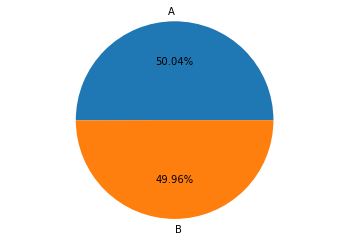

In [28]:
# Creating a new A/B test variable. A if a person recieved a fitness test and B if someone does not
data['A/B_Group'] = data.fitness_test_date.apply(lambda i: 'A' if pd.notnull(i) else 'B')

# Checking the counts of each group
counts = data['A/B_Group'].value_counts()
print('Counts for each group:')
print(counts)

# Percentage breakdown for each group
print('Percentage Breakdown:')
print(data['A/B_Group'].value_counts(normalize=True))

# Pie Chart
plt.pie(counts, labels=['A', 'B'], autopct='%0.2f%%')
plt.axis('equal')
plt.show()

The sign-up process for MuscleHub has several steps:

1. Take a fitness test with a personal trainer (only Group A).
2. Fill out an application for the gym.
3. Send in their payment for their first month's membership.

We will determine the percentage of people in each group who complete Step 2, filling out an application.

In [55]:
# Creating our is_application column
data['is_application'] = data.application_date.apply(lambda i: 'Application' if pd.notnull(i) else 'No Application')

# Creating our new app counts data frame
app_counts = data.groupby(['A/B_Group', 'is_application']).first_name.count().reset_index()

# Creating a pivot of our data
app_pivot = app_counts.pivot(
    index = 'A/B_Group',
    columns = 'is_application',
    values = 'first_name'
).reset_index()


# Creating a total variable
app_pivot['Total'] = app_pivot['Application'] + app_pivot['No Application']

# Creating Percentage Application
app_pivot['% Application'] = app_pivot['Application'] / app_pivot['Total']

app_pivot


is_application,A/B_Group,Application,No Application,Total,% Application
0,A,250,2254,2504,0.09984
1,B,325,2175,2500,0.13000


In [57]:
# Calculating the statistical significance of applications
app_obvs = [[250, 2254], [325, 2175]]

chi2, p, dof, ex = chi2_contingency(app_obvs)
print('P Value:', p)
print('With a significance threshold of 0.05 this indicates that there is a statistically significant difference between the two groups.')

P Value: 0.0009647827600722304
With a significance threshold of 0.05 this indicates that there is a statistically significant difference between the two groups.


In [56]:
# Determining the count of memberships from applications

# Creating the is_member variable 
data['is_member'] = data.purchase_date.apply(lambda i: 'Member' if pd.notnull(i) else 'Not a Member')

# Creating a member counts data frame
member_counts = data.groupby(['A/B_Group', 'is_member']).first_name.count().reset_index()

# Creating the member pivot
member_pivot = member_counts.pivot(
    index = 'A/B_Group',
    columns = 'is_member',
    values = 'first_name'
).reset_index()

# Creating a total variable
member_pivot['Total'] = member_pivot['Member'] + member_pivot['Not a Member']

# Creating a % member variable
member_pivot['% Member'] = member_pivot['Member'] / member_pivot['Total']

member_pivot


is_member,A/B_Group,Member,Not a Member,Total,% Member
0,A,200,2304,2504,0.079872
1,B,250,2250,2500,0.100000


In [61]:
# Calculating the statistical significance
member_obvs = [[200, 2304], [250, 2250]]

chi2, p, dof, ex = chi2_contingency(member_obvs)

print('P Value:', p)
print('With a significance threshold of 0.05 this indicates that there is a statistically significant difference between the two groups.')

P Value: 0.014724114645783203
With a significance threshold of 0.05 this indicates that there is a statistically significant difference between the two groups.
